Notebook criado para aplicação dos conhecimentos sobre previsões de séries temporais utilizando os modelos ARIMA, SARIMA e SARIMAX.
Considero esse tema como um dos mais difíceis de machine learning, por isso esse notebook estara em constante atualização conforme eu for melhorando meus conhecimentos.

Objetivo: Criar um modelo para realizar previsões de demanda dos passageiros em empresas aéreas.

In [1]:
!pip install pmdarima

In [2]:
# todas as importações que serão necessárias durante a criação do modelo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tools.eval_measures import rmse, mse
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.tools import diff
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA,ARIMA,ARMAResults, ARIMAResults
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


In [2]:
#utilização do colab para importar os arquivos
from google.colab import files
files.upload()

{}

In [3]:
df = pd.read_csv("airline_passengers.csv", parse_dates=True, index_col=0)

In [4]:
df.index.freq="MS"

In [5]:
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [6]:
df.isnull().sum()

Thousands of Passengers    0
dtype: int64

In [7]:
df.describe()

,Thousands of Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


Passado a primeira parte da análise dos dados, definição do índice como a data, podemos visualizar o dataset durante o tempo. Vemos que: 

1 - Existe uma tendência de alta

2 - Existe sazonalidade em períodos

Text(0.5, 0, 'Time')

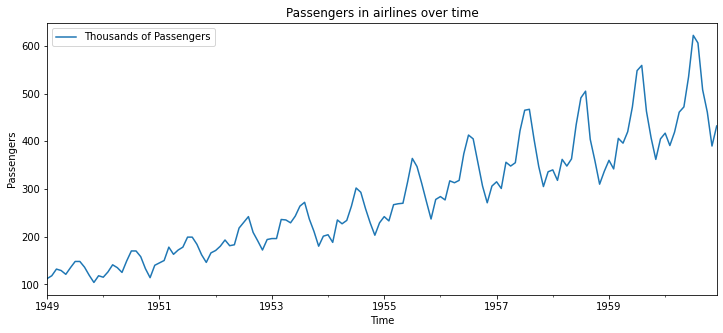

In [8]:
plt.figure(figsize=(12,5))
df['Thousands of Passengers'].plot(legend=True)
plt.title("Passengers in airlines over time")
plt.ylabel("Passengers")
plt.xlabel("Time")

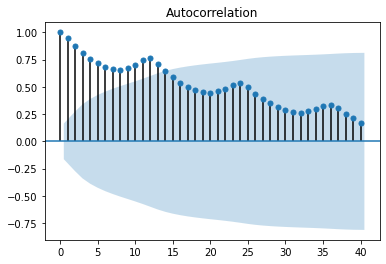

In [9]:
plot_acf(df['Thousands of Passengers'], lags=40);

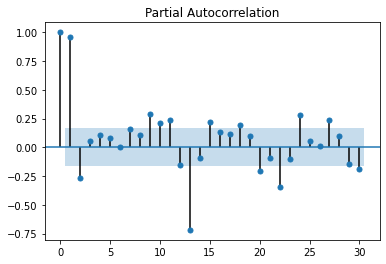

In [10]:
plot_pacf(df['Thousands of Passengers'], lags=30);

In [11]:
seasonal = seasonal_decompose(df['Thousands of Passengers'], model='multiplicative');

Podemos então dividir o primeiro gráfico entre a tendência, a sazonalidade e o residuo

A tendência é em que forma que o gráfico está se aprensentando? Em alta? Em queda?

Sazonalidade é os períodos que se repetem, por exemplo, no inverno as pessoas costumam viajar mais do que no verão, e isso se repete todo ano

Residuo é tudo aquilo que não pode ser explicado pela tendência e pela sazonalidade

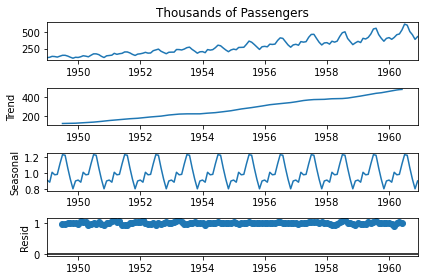

In [12]:
seasonal.plot();

Vemos claramente nesse gráfico que existe uma sazonalidade , tendo uma alta no verão e uma baixa de demanda no inverno

Text(0.5, 0, 'Date')

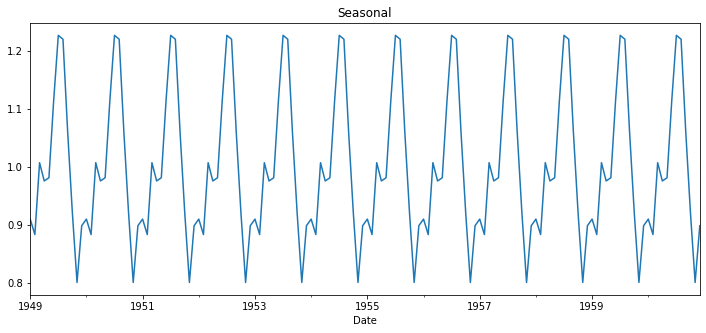

In [13]:
plt.figure(figsize=(12,5))
seasonal.seasonal.plot();
plt.title("Seasonal")
plt.xlabel('Date')

Text(0.5, 0, 'Date')

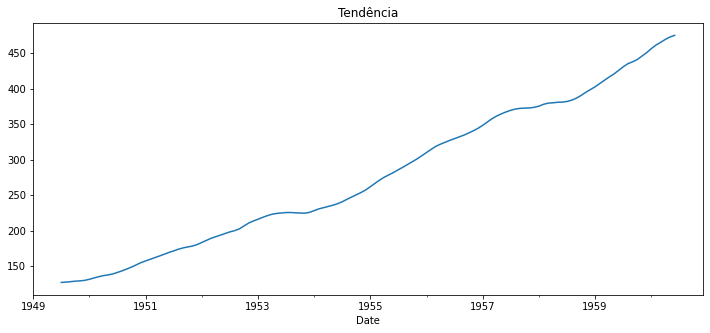

In [14]:
plt.figure(figsize=(12,5))
seasonal.trend.plot()
plt.title("Tendência")
plt.xlabel('Date')

Text(0.5, 0, 'Date')

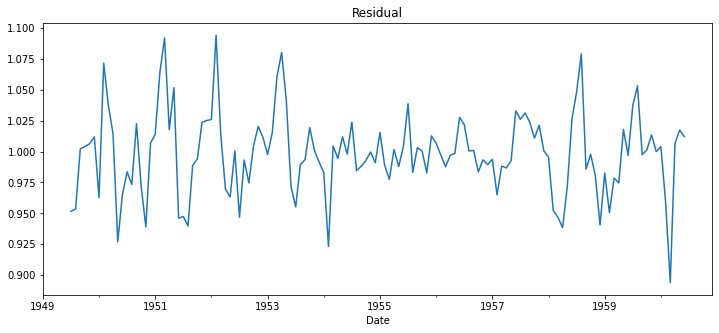

In [15]:
plt.figure(figsize=(12,5))
seasonal.resid.plot()
plt.title("Residual")
plt.xlabel('Date')

A seguir devemos então verificar se a série é estacionária ou não, para isso é utilizaremos o teste do adfuller

O seguinte teste retornará uma tupla de estatísticas do teste do ADF, como Estatística do teste Valor-P; Número de defasagens usadas; Número de observações usadas para a regressão do ADF e um dicionário de Valores críticos.

Resumindo, se o valor-p encontrado pelo teste for < 0,05, a série é estacionária, ja se o valor for acima de 0,05 a série não é estacionária e por esse motivo devemos então normalizala. 

Utilizei uma função para simplificar a visualização dos valores, e o valor p encontrado foi superior a 0,05, ou seja, a série não é estacionaria. 

In [16]:
# função criada para uma melhor visualização dos resultados do adfuller test
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [17]:
adf_test(df['Thousands of Passengers'])

Augmented Dickey-Fuller Test: 
ADF test statistic        0.815369
p-value                   0.991880
# lags used              13.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


Como podemos transformar uma série não estacionária, em uma série estacionária? Podemos aplicar simplesmente a "differencing":

Text(0, 0.5, 'Date')

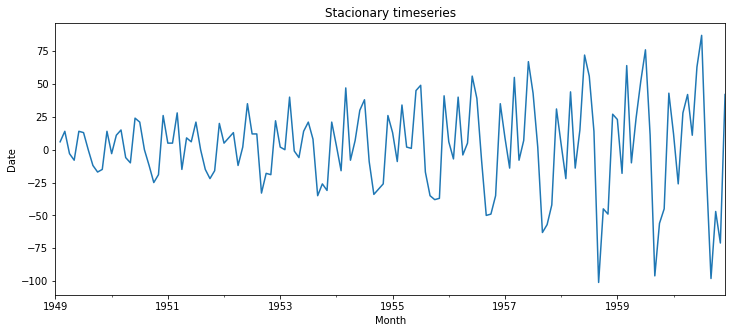

In [18]:
df1 = df.copy()
plt.figure(figsize=(12,5))
df1['d1'] = diff(df1['Thousands of Passengers'],k_diff=1)
df1['d1'].plot();
plt.title("Stacionary timeseries")
plt.ylabel("Date")

MODELO SARIMA

De uma forma resumida, o ARIMA model é composto por: 

AR(p) = Autoregression model, prevemos utilizando a combinação de valores passados da próprima variável. Gera modelos lineares. Representado pela letra P
MA(d) = é o modelo de média móvel.
ARMA(p,q) = A junção dos dois acima - representado pela letra Q
ARIMA(p,q,d) = O mesmo processo que ocorre para o ARMA + aplicação da diferenciação para tornar a série estacionária.

Temos então o SARIMAX (termo genérico), além dos parâmetros (p,q,d) aceita também o (P,D,Q)m, descrevendo os componentes sazonais. P,D e Q representa a regressão sazonal, diferenciação, e média movel, m representa o número de pontos para cada ciclo.

O X representa a variável exógena, como não utilizaremos ela, não entrarei em maiores detalhes.

Para a definição dos melhores parâmetros existe a forma manual e a forma automática, onde a função definirá os melhores parâmetros para nós...

Função: Auto_arima, devo informar ainda o meu dataset, definir os pontos de start do "p" e do "q", definir a sazonalidade e o período de sazonalidade, no caso são de 12 meses.

O objetivo é achar os melhores parâmetros em base no valor AIC, que deve ser o menor possível, com a menor complexidade


In [19]:
sarima = auto_arima(df['Thousands of Passengers'],start_p=0, start_q=0,
           seasonal=True,trace=True, m=12)

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(1,1,1,12) [intercept=True]; AIC=1034.075, BIC=1045.576, Time=0.766 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=1033.479, BIC=1039.229, Time=0.029 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=1022.316, BIC=1033.817, Time=0.558 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=1022.904, BIC=1034.405, Time=0.681 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=1031.508, BIC=1034.383, Time=0.027 seconds
Fit ARIMA(1,1,0)x(0,1,0,12) [intercept=True]; AIC=1022.343, BIC=1030.968, Time=0.132 seconds
Fit ARIMA(1,1,0)x(2,1,0,12) [intercept=True]; AIC=1021.137, BIC=1035.513, Time=1.756 seconds
Fit ARIMA(1,1,0)x(2,1,1,12) [intercept=True]; AIC=1017.166, BIC=1034.417, Time=6.089 seconds
Near non-invertible roots for order (1, 1, 0)(2, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA(1,1,0)x(1,1,1,12) [intercept=True]; AIC=102

In [20]:
sarima

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(2, 1, 1, 12),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

Temos então com o modelo ARIMA(0,1,1) que com a seasonal order (2,1,1,12) se transforma em SARIMA

In [21]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -501.920
Date:                            Mon, 06 Jul 2020   AIC                           1015.841
Time:                                    01:22:00   BIC                           1033.092
Sample:                                         0   HQIC                          1022.850
                                            - 144                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.032      0.010      0.992      -0.062       0.063
ma.L1         -0.4243      0.068     -6.211      0.000      -0.558      -0.290
ar.S.L12       0.6656      0.155      4.296      0.000       0.362       0.969
ar.S.L24       0.3330      0.096      3.479      0.001       0.145       0.521
ma.S.L12      -0.9754      1.265     -0.771      0.441      -3.454       1.503
sigma2       110.3992    117.291      0.941      0.347    -119.486     340.285
===================================================================================
Ljung-Box (Q):                       53.12   Jarque-Bera (JB):                 7.57
Prob(Q):                              0.08   Prob(JB):                         0.02
Heteroskedasticity (H):               2.83   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
train = df.iloc[:132]
test = df.iloc[132:]

In [25]:
start = len(train)
end = len(train) + len(test) - 1

In [26]:
model = SARIMAX(train['Thousands of Passengers'], order=(0, 1, 1),seasonal_order=(2, 1, 1, 12)).fit()

In [27]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:            Thousands of Passengers   No. Observations:                  132
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -443.012
Date:                            Mon, 06 Jul 2020   AIC                            896.024
Time:                                    01:22:37   BIC                            909.920
Sample:                                01-01-1949   HQIC                           901.667
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2984      0.075     -3.972      0.000      -0.446      -0.151
ar.S.L12       0.7098      0.231      3.067      0.002       0.256       1.163
ar.S.L24       0.2894      0.100      2.888      0.004       0.093       0.486
ma.S.L12      -0.9816      2.373     -0.414      0.679      -5.632       3.669
sigma2        88.1476    190.644      0.462      0.644    -285.509     461.804
===================================================================================
Ljung-Box (Q):                       38.26   Jarque-Bera (JB):                 0.00
Prob(Q):                              0.55   Prob(JB):                         1.00
Heteroskedasticity (H):               1.62   Skew:                            -0.00
Prob(H) (two-sided):                  0.13   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Após a divisão de dataset de treino e dataset de test, treinamos nosso modelo e então podemos verificar como nosso modelo performou

In [28]:
predictions = model.predict(start,end,typ="levels").rename("SARIMAX(0, 1, 1)x(2, 1, 1, 12)")

Text(0.5, 0, 'Date')

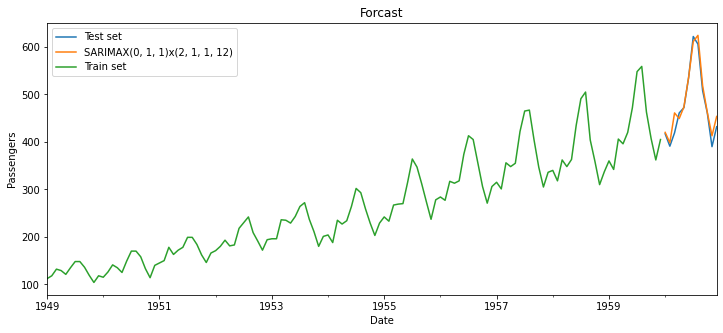

In [29]:
plt.figure(figsize=(12,5))
test['Thousands of Passengers'].plot(label="Test set",legend=True)
predictions.plot(legend=True)
train['Thousands of Passengers'].plot(label = "Train set",legend=True)
plt.title("Forcast")
plt.ylabel('Passengers')
plt.xlabel("Date")

Dando um zoom na nossa previsão, podemos ver que o modelo fez boas previsões, e chegou próximo ao real. As métricas utilizadas para verificar a performance do nosso modelo será o Mean Absolute Error e Root Mean Squared Error

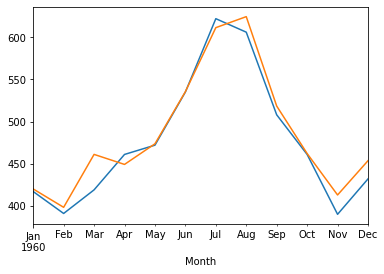

In [30]:
test['Thousands of Passengers'].plot()
predictions.plot()

In [31]:
mse(test['Thousands of Passengers'],predictions)

294.0151968831293

In [32]:
rmse(test['Thousands of Passengers'],predictions) #valor muito bom comparado com a média dos passageiros no mesmo período

17.14687134386706

In [33]:
start = len(df['Thousands of Passengers'])
end = len(df['Thousands of Passengers']) + 24

Após definirmos o modelo, podemos então realizar o treinamento no dataset completo, e realizar previsões para o futuro... no caso defini que irei fazer previsões para os próximos 24 meses

In [34]:
model = SARIMAX(df['Thousands of Passengers'], order=(0, 1, 1),seasonal_order=(2, 1, 1, 12)).fit()

In [35]:
predictions = model.predict(start,end,typ="levels").rename("SARIMAX(0, 1, 1)x(2, 1, 1, 12) - Final")

Text(0.5, 1.0, 'Forcast Passengers')

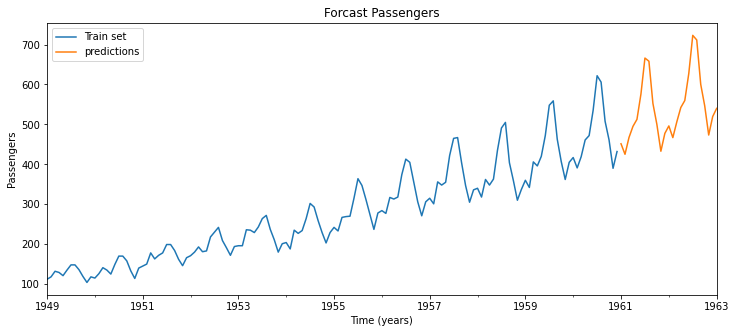

In [36]:
plt.figure(figsize=(12,5))
df['Thousands of Passengers'].plot(label="Train set", legend=True)
predictions.plot(label = "predictions", legend=True)
plt.ylabel("Passengers")
plt.xlabel("Time (years)")
plt.title("Forcast Passengers")